In [2]:
import sys
print(sys.executable)

c:\Program Files\Python311\python.exe


In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.20.0
Num GPUs Available: 0


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, ReLU, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

# -------------------------------
# CONFIGURATION
# -------------------------------
seed = 0
np.random.seed(seed)

# Load data
X_train = pd.read_csv("X_train_Norway.csv")
X_test = pd.read_csv("X_test_Norway.csv")
y_train = pd.read_csv("y_train_Norway.csv").values.ravel()
y_test = pd.read_csv("y_test_Norway.csv").values.ravel()

# Label encode
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
n_classes = len(le.classes_)

# SMOTE
sm = SMOTE(random_state=seed)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train_enc)

# One-hot encode labels
y_train_oh = to_categorical(y_train_sm, num_classes=n_classes)
y_test_oh = to_categorical(y_test_enc, num_classes=n_classes)

input_dim = X_train_sm.shape[1]

# -------------------------------
# AUTOENCODER (fixed)
# -------------------------------
def build_autoencoder(input_dim, encoding_dim=500, hidden_dim1=5000, hidden_dim2=2000, 
                      l2_reg=1e-14, learning_rate=3e-5):
    """Build encoder + autoencoder"""
    inp = Input(shape=(input_dim,))
    x = Dense(hidden_dim1, kernel_regularizer=regularizers.l2(l2_reg))(inp)
    x = ReLU()(x)
    x = Dense(hidden_dim2, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = ReLU()(x)
    encoded = Dense(encoding_dim, kernel_regularizer=regularizers.l2(l2_reg))(x)
    encoded = ReLU()(encoded)
    
    # Decoder
    x = Dense(hidden_dim2, kernel_regularizer=regularizers.l2(l2_reg))(encoded)
    x = ReLU()(x)
    x = Dense(hidden_dim1, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = ReLU()(x)
    decoded = Dense(input_dim, activation='linear')(x)
    
    autoencoder = Model(inputs=inp, outputs=decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['accuracy'])
    
    encoder = Model(inputs=inp, outputs=encoded)
    return autoencoder, encoder

autoencoder, encoder = build_autoencoder(input_dim)
autoencoder.fit(X_train_sm, X_train_sm, epochs=100, batch_size=32, verbose=1, shuffle=True)

# Encode features
X_train_encoded = encoder.predict(X_train_sm)
X_test_encoded = encoder.predict(X_test)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.0000e+00 - loss: 0.1325
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.0022 - loss: 0.0156
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.0000e+00 - loss: 0.0058
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3957 - loss: 0.0044
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8065 - loss: 0.0042
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8065 - loss: 0.0041
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8065 - loss: 0.0041
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8065 - loss: 0.0041
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8065 - loss: 0.0041
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8065 - loss: 0.0041
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8065 - loss: 0.0041
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - a

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=   7.0s
[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=   6.7s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   6.8s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   6.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=64, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1_l2; total time=   5.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=64, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1_l2; total time=   5.2s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.2, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l1_l2; total time=   6.7s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.2, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l1_l2; total time=   6.9s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1; total time=   6.7s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1; total time=   6.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=32, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=   6.1s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=32, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=   5.7s
[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   5.6s
[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   5.6s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1_l2; total time=   5.7s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1_l2; total time=   5.7s
[CV

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.2, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=None; total time=   6.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.2, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=None; total time=   6.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=64, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l2; total time=   5.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=64, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l2; total time=   5.0s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1; total time=   6.6s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1; total time=   7.2s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.2, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1; total time=   6.6s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.2, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1; total time=   6.6s
[CV] END batch_size=

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=64, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=None; total time=   5.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=64, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=None; total time=   5.0s
[CV] END batch_size=64, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l1; total time=   5.0s
[CV] END batch_size=64, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l1; total time=   5.0s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l1_l2; total time=   5.6s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l1_l2; total time=   5.7s
[CV] END

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l2; total time=   6.6s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l2; total time=   6.6s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.2, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1; total time=   7.3s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.2, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1; total time=   6.6s
[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.1, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l1_l2; total time=   6.7s
[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.1, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l1_l2; total time=   6.7s
[CV] END ba

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=32, model__activation=leakyrelu, model__dropout_rate1=0.1, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1; total time=   5.6s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=32, model__activation=leakyrelu, model__dropout_rate1=0.1, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1; total time=   5.6s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=   5.7s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=   5.7s
[CV] END batch_size=64, model__activation=relu, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l2; total time=   5.3s
[CV] END batch_size=64, model__activation=relu, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l2; total time=   5.8s
[CV] END

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.1, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   7.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.1, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   7.8s
[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l1; total time=   7.9s
[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l1; total time=   7.6s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l2; total time=   6.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l2; total time=   6.5s
[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l2; total time=   5.7s
[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l2; total time=   5.6s
[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l2; total time=   5.6s
[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l2; total time=   5.6s
[CV] END batch

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=32, model__activation=leakyrelu, model__dropout_rate1=0.2, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l2; total time=   5.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=32, model__activation=leakyrelu, model__dropout_rate1=0.2, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l2; total time=   6.0s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.1, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l1; total time=   6.9s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.1, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l1; total time=   5.7s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=None; total time=   6.4s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=None; total time=   6.4s
[CV] END b

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.2, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l1; total time=   6.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.2, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l1; total time=   6.6s
[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   6.4s
[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   6.4s
[CV] END batch_size=64, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l1; total time=   5.0s
[CV] END batch_size=64, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l1; total time=   5.0s
RandomizedS

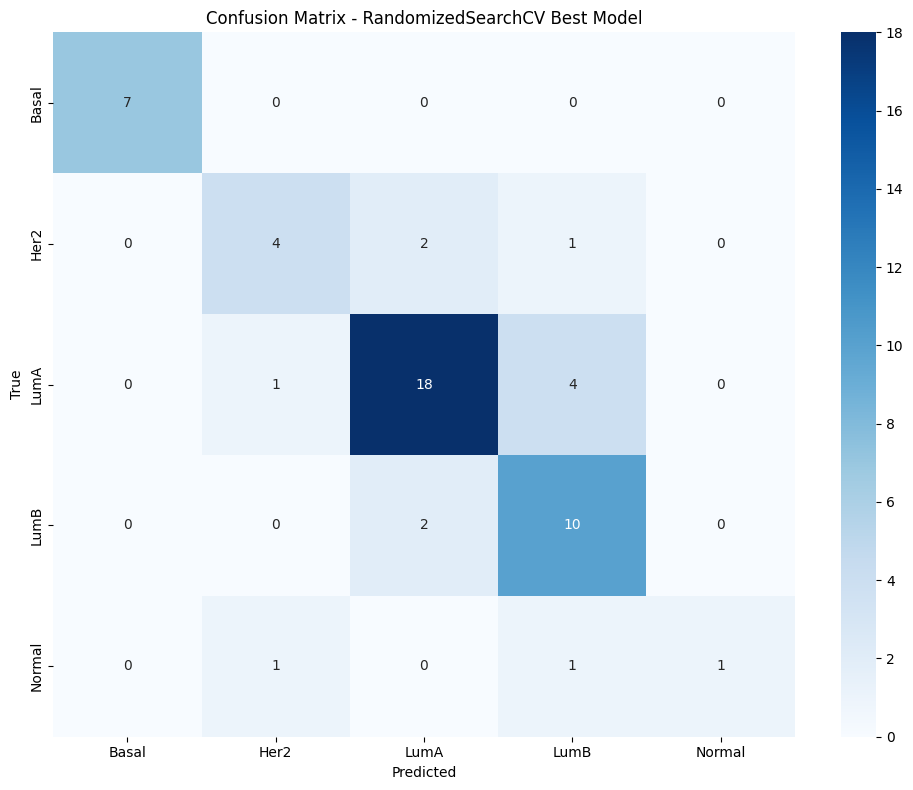

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, ReLU, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier


def create_classifier(hidden_dim=200, dropout_rate1=0.2, dropout_rate2=0.3, 
                      learning_rate=2e-5, activation='relu', regularization=None):
    inp = Input(shape=(X_train_encoded.shape[1],))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rate1, seed=seed)(x)

    # Choose regularization
    if regularization == 'l1':
        reg = regularizers.l1(1e-14)
    elif regularization == 'l2':
        reg = regularizers.l2(1e-14)
    elif regularization == 'l1_l2':
        reg = regularizers.l1_l2(1e-14, 1e-14)
    else:
        reg = None

    # Activation
    if activation == 'leakyrelu':
        x = Dense(hidden_dim, kernel_regularizer=reg)(x)
        x = LeakyReLU(alpha=0.01)(x)
    elif activation == 'relu':
        x = Dense(hidden_dim, kernel_regularizer=reg)(x)
        x = ReLU()(x)
    else:
        x = Dense(hidden_dim, activation='tanh', kernel_regularizer=reg)(x)

    x = BatchNormalization()(x)
    x = Dropout(dropout_rate2, seed=seed)(x)
    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap with KerasClassifier
clf = KerasClassifier(
    model=create_classifier,
    epochs=100,
    verbose=0,
    random_state=seed,
)

# -------------------------------
# RANDOMIZED SEARCH
# -------------------------------
param_dist = {
    'model__hidden_dim': [200],
    'model__dropout_rate1': [0.1, 0.2, 0.3],
    'model__dropout_rate2': [0.1, 0.2, 0.3, 0.4, 0.5],
    'model__learning_rate': [0.01, 0.002, 0.001, 0.0001],
    'model__activation': ['relu', 'tanh', 'leakyrelu'],
    'model__regularization': [None, 'l1', 'l2', 'l1_l2'],
    'batch_size': [16, 32, 64],
}

random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_weighted',
    cv=2,
    random_state=seed,
    verbose=2
)

start = time.time()
random_search.fit(X_train_encoded, y_train_sm)
end = time.time()
print(f"RandomizedSearchCV completed in {(end-start)/60:.2f} minutes")

# -------------------------------
# EVALUATION
# -------------------------------
best_model = random_search.best_estimator_

y_pred_classes = best_model.predict(X_test_encoded)
print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - RandomizedSearchCV Best Model')
plt.tight_layout()
plt.show()


Classification Report (Fixed Classifier):
              precision    recall  f1-score   support

       Basal       1.00      1.00      1.00         7
        Her2       0.67      0.57      0.62         7
        LumA       0.82      0.78      0.80        23
        LumB       0.62      0.83      0.71        12
      Normal       1.00      0.33      0.50         3

    accuracy                           0.77        52
   macro avg       0.82      0.70      0.73        52
weighted avg       0.79      0.77      0.76        52



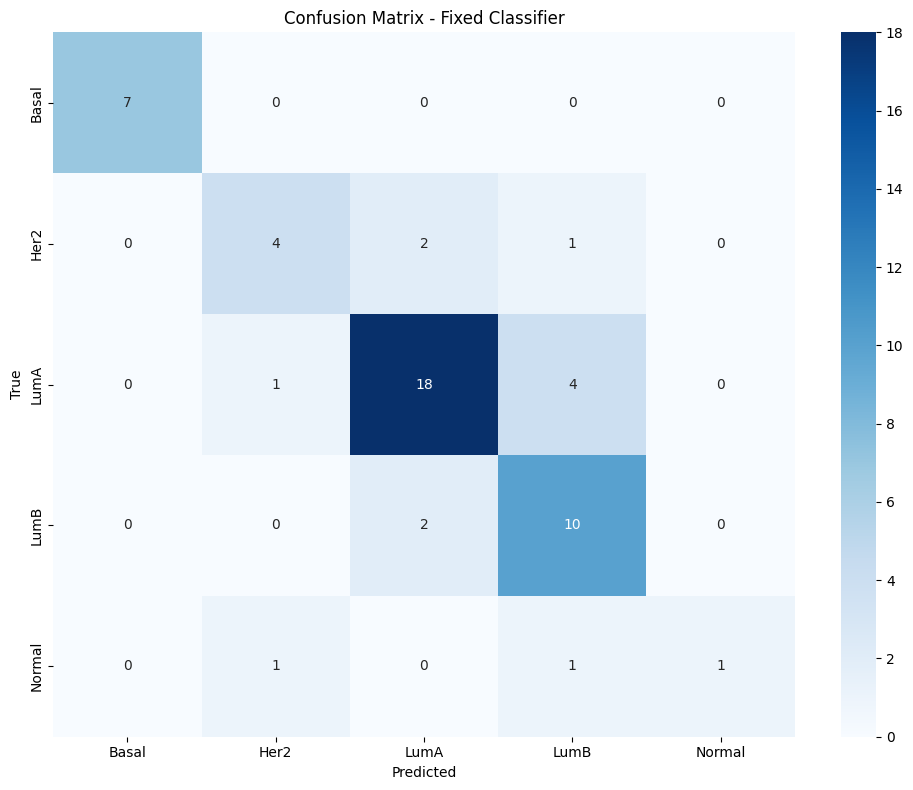

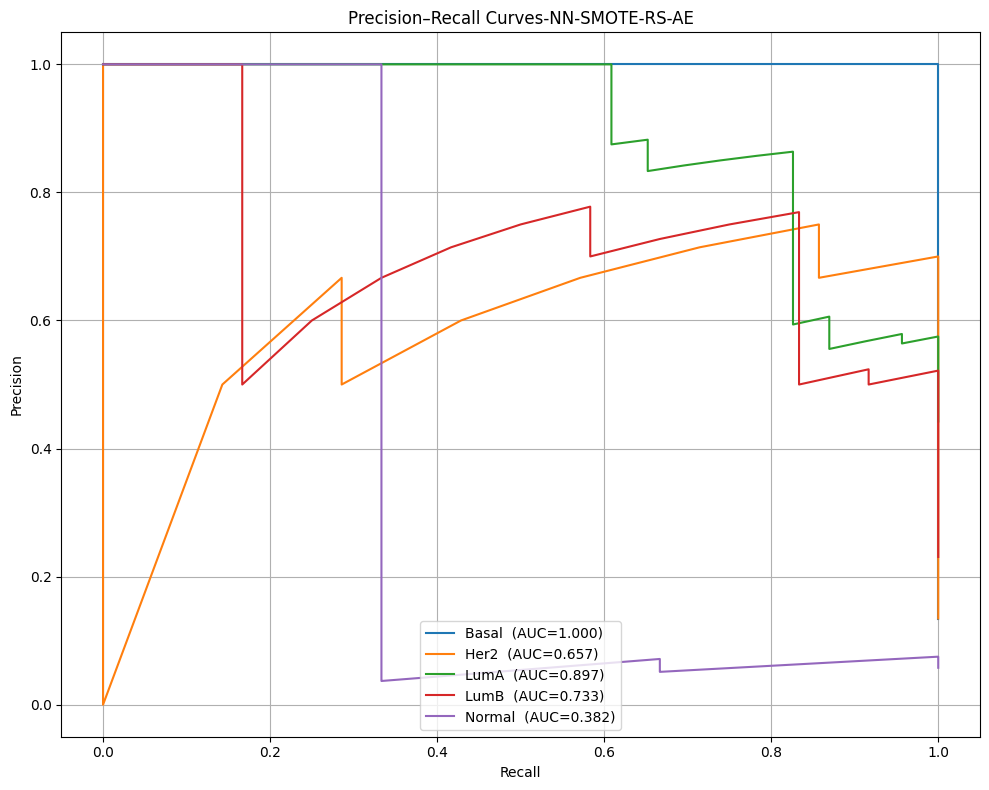


No training history found — skipping accuracy/loss plots.


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Predict probabilities and classes
y_pred_proba = best_model.predict_proba(X_test_encoded)
y_pred_classes = best_model.predict(X_test_encoded)

# -------------------------------
# CLASSIFICATION REPORT
# -------------------------------
print("\nClassification Report (Fixed Classifier):")
print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))

# -------------------------------
# CONFUSION MATRIX
# -------------------------------
cm = confusion_matrix(y_test_enc, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Fixed Classifier')
plt.tight_layout()
plt.show()

# -------------------------------
# PRECISION–RECALL CURVE (MICRO-AVERAGE)
# -------------------------------
# Convert predictions into the max probability for each sample
y_score = np.max(y_pred_proba, axis=1)

# Convert true labels to 1 if correct, 0 otherwise
y_test_binarized = label_binarize(y_test_enc, classes=range(len(le.classes_)))

plt.figure(figsize=(10, 8))


for i, class_name in enumerate(le.classes_):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f"{class_name}  (AUC={auc_score:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves-NN-SMOTE-RS-AE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# -------------------------------
# TRAINING HISTORY PLOTS (if available)
# -------------------------------
if 'history' in globals():
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("\nNo training history found — skipping accuracy/loss plots.")


In [4]:
print("\nBest Keras model parameters:")
print(best_model.get_params())


Best Keras model parameters:
{'model': <function create_classifier at 0x000002A26FB07240>, 'build_fn': None, 'warm_start': False, 'random_state': 0, 'optimizer': 'rmsprop', 'loss': None, 'metrics': None, 'batch_size': 16, 'validation_batch_size': None, 'verbose': 0, 'callbacks': None, 'validation_split': 0.0, 'shuffle': True, 'run_eagerly': False, 'epochs': 100, 'class_weight': None, 'model__regularization': None, 'model__learning_rate': 0.002, 'model__hidden_dim': 200, 'model__dropout_rate2': 0.3, 'model__dropout_rate1': 0.1, 'model__activation': 'tanh'}
